In [74]:
from Landau_Potential_Diffusion import *
from curvature import *

from PyAstronomy import pyaC
import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

In [134]:
def get_local_min_max(x_dat, y_dat, pot_dat, return_max_three = False):

    # Get coordinates and indices of zero crossings
    xc, xi = pyaC.zerocross1d(x_dat, y_dat, getIndices=True)
    xc_min = xc[np.where(y_dat[xi]>0.0)]
    xc_max = xc[np.where(y_dat[xi]<0.0)]

    #Test whether potential at smallest MSE value is smaller than the local minimum
    xc_min[0] = x_dat[0] if pot_dat[0]<np.interp(xc_min[0], x_dat, pot_dat) else xc_min[0]
    
    if return_max_three:
        #assume bimodality: look for the largest local maximum and the two smallest minima
        xc_min = xc_min[np.argsort(np.interp(xc_min, x_dat, pot_dat))][:2]
        xc_max = xc_max[np.argsort(np.interp(xc_max, x_dat, pot_dat))][-1]
    
    return xc_min, xc_max, xi, np.interp(xc_min, x_dat, pot_dat), np.interp(xc_max, x_dat, pot_dat)

In [160]:
def get_bimodal_peaks(bins_fmse, hist_fmse):
    
    ind_max = np.squeeze(argrelextrema(hist_fmse, np.greater))
    bins_fmse_max = bins_fmse[ind_max]
    hist_fmse_max = hist_fmse[ind_max]

    # Take the two largest maxima
    if len(ind_max)>2:
        bins_fmse_max = bins_fmse_max[np.argsort(hist_fmse_max)][-2:]
        ind_max  = np.array(ind_max)[np.argsort(hist_fmse_max)][-2:]
        hist_fmse_max = np.sort(hist_fmse_max)[-2:]
        
    # Calculate the antimode 
    
    ind_min       = np.nan
    bins_fmse_min = np.nan
    hist_fmse_min = np.nan
    
    if len(ind_max) == 2:
        ind_between_peaks = np.where((bins_fmse>np.min(bins_fmse_max))&(bins_fmse<np.max(bins_fmse_max)))
        ind_min = np.argmin(hist_fmse[ind_between_peaks])
        hist_fmse_min = hist_fmse[ind_between_peaks][ind_min]
        bins_fmse_min = bins_fmse[ind_between_peaks][ind_min]
        
    return bins_fmse_max, ind_max, hist_fmse_max, bins_fmse_min, ind_min, hist_fmse_min

In [2]:
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_%i_%ikm_%ix%i/output/'

In [3]:
dx  = 3
L_dom = 206

In [4]:
RCE295 = xr.open_mfdataset(path%(295, dx, L_dom, L_dom)+'lfff[0-9]???????.nc')
RCE300 = xr.open_mfdataset(path%(300, dx, L_dom, L_dom)+'lfff[0-9]???????.nc')
RCE305 = xr.open_mfdataset(path%(305, dx, L_dom, L_dom)+'lfff[0-9]???????.nc')

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global d

In [5]:
RCE_exps = [RCE295, RCE300, RCE305]
SST_exps = [295, 300, 305]

In [6]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

## Bimodality

PW Interquartile range

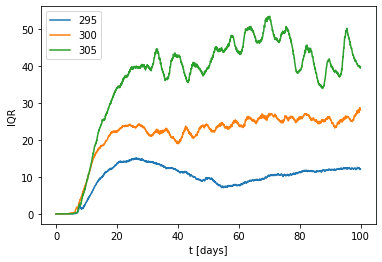

In [7]:
for i_exp, RCE_data in enumerate(RCE_exps):
    TQV_IQR = np.percentile(a=RCE_data.TQV[:,:,:],q=75,axis=(1,2))-np.percentile(a=RCE_data.TQV[:,:,:],q=25,axis=(1,2))
    plt.plot(tcoor/(24*3600),TQV_IQR, label = SST_exps[i_exp])
plt.xlabel('t [days]')
plt.ylabel('IQR')
plt.legend()

Final Humidity Distribution

In [8]:
# Calculate histogram for final days

day_range = range(75, 100)
Nbins = 30
bins_mid_A = []

fmse_hist_2D = np.ones((len(RCE_exps), len(day_range), Nbins-1))

for i_exp, RCE_data in enumerate(RCE_exps):
    
    FMSE_min = RCE_data.FMSE.min().values
    FMSE_max = RCE_data.FMSE.max().values

    fmse_bins = np.linspace(FMSE_min, FMSE_max, num = Nbins)
    fmse_bin_mid = 0.5*(fmse_bins[:-1]+fmse_bins[1:])
    delta_fmse_bin = fmse_bins[1] - fmse_bins[0]

    bins_mid_A.append(fmse_bin_mid)
    
    for i_d, day in enumerate(day_range): 
        iT_d = np.arange(24*day,24*(day+1),1)
        field_hist, bin_edges = np.histogram(RCE_data.FMSE[iT_d,:,:].values.flatten(),bins=fmse_bins, density = True)
        fmse_hist_2D[i_exp, i_d, :] = field_hist

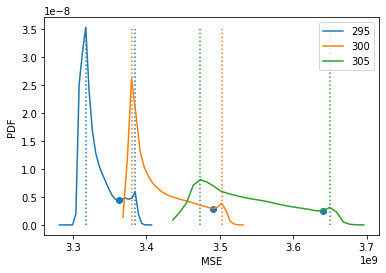

In [162]:
fmse_hist_mean = np.mean(fmse_hist_2D, axis = 1)
bins_fmse_max_set = []
hist_fmse_max_set = []
bins_fmse_min_set = []
hist_fmse_min_set = []

for i_exp, RCE_data in enumerate(RCE_exps):
    plt.plot(bins_mid_A[i_exp], fmse_hist_mean[i_exp,:], label = SST_exps[i_exp])
    
    # Calculate position of the peaks in the distribution
    bins_fmse_max, ind_max, hist_fmse_max, bins_fmse_min, ind_min, hist_fmse_min = get_bimodal_peaks(bins_mid_A[i_exp], fmse_hist_mean[i_exp,:])
    plt.vlines(bins_fmse_max, 0.0, 3.5e-8, linestyle = ':', color = 'C%i'%i_exp)
    
    bins_fmse_max_set.append(bins_fmse_max)
    hist_fmse_max_set.append(hist_fmse_max)
    bins_fmse_min_set.append(bins_fmse_min)
    hist_fmse_min_set.append(hist_fmse_min)
    
plt.xlabel('MSE')
plt.ylabel('PDF')
plt.legend()

## Potential

Calculate dMSE/dt

In [10]:
t_range = np.arange(0,np.size(RCE_data.time)-2)
dMSE_dt_set = []

for i_exp, RCE_data in enumerate(RCE_exps):
    dMSE_dt = (RCE_data.FMSE.values[t_range+2,:,:]-RCE_data.FMSE.values[t_range,:,:])/(2*dt)
    dMSE_dt = np.concatenate((dMSE_dt[0:1,:,:],dMSE_dt,np.tile(dMSE_dt[-1,:,:],(1,1,1))),axis=0)
    
    dMSE_dt_set.append(dMSE_dt)

In [11]:
binm_iT_set = []
V_iT_set    = []
FMSE_cond_mean_set =[]
FMSE_cond_std_set = []

for i_exp, RCE_data in enumerate(RCE_exps): 
    iT_d = np.arange(24*75,24*100,1)
    binm_iT, V_iT, FMSE_cond_mean, FMSE_cond_std = potential(RCE_data.FMSE[iT_d,:,:],dMSE_dt_set[i_exp][iT_d,:,:], Nbins = Nbins)
    
    binm_iT_set.append(binm_iT)
    V_iT_set.append(V_iT)
    FMSE_cond_mean_set.append(FMSE_cond_mean)
    FMSE_cond_std_set.append(FMSE_cond_std)

## Compare Potential and Bimodal distribution

### Compare location of potential minima and the maxima in the PDF

No handles with labels found to put in legend.


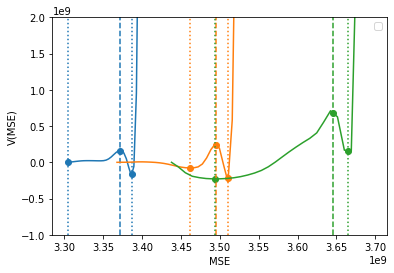

In [139]:
x_pot_max_set = []
x_pot_min_set = []
Vmin_set      = []
Vmax_set      = []

for i_exp, RCE_data in enumerate(RCE_exps):
    
    plt.plot(binm_iT_set[i_exp], V_iT_set[i_exp])
    
    #Calculate local minima and maxima using the conditional mean of the FMSE tendencies
    xc_min, xc_max, xi, Vmin, Vmax = get_local_min_max(binm_iT_set[i_exp], np.squeeze(FMSE_cond_mean_set[i_exp]), np.squeeze(V_iT_set[i_exp]), return_max_three=True)
    plt.vlines(xc_min, -1e9, 2e9, linestyle = ':', color = 'C%i'%i_exp) 
    plt.vlines(xc_max, -1e9, 2e9, linestyle = '--', color = 'C%i'%i_exp) 
    
    x_pot_min_set.append(xc_min)
    x_pot_max_set.append(xc_max)  
    Vmin_set.append(Vmin)
    Vmax_set.append(Vmax)
    
    plt.scatter(xc_min, Vmin, color = 'C%i'%i_exp)
    plt.scatter(xc_max, Vmax, color = 'C%i'%i_exp)
    
plt.xlabel('MSE')
plt.ylabel('V(MSE)')
plt.ylim(ymin = -1e9, ymax = 2e9)
plt.legend()

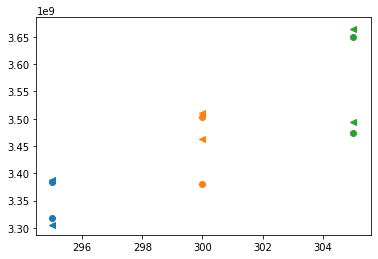

In [131]:
for i_exp, RCE_data in enumerate(RCE_exps):
    plt.scatter(SST_exps[i_exp]*np.ones(len(x_pot_min_set[i_exp])), x_pot_min_set[i_exp], marker = '<', color = 'C%i'%i_exp)
    plt.scatter(SST_exps[i_exp]*np.ones(len(x_pot_min_set[i_exp])), bins_fmse_max_set[i_exp], color = 'C%i'%i_exp)

### Calculate energy barrier between potential minima (B) and compare to the Bimodality Amplitude (A_B)

Def. of Bimodality amplitude see https://en.wikipedia.org/wiki/Multimodal_distribution

In [142]:
B = np.ones(len(RCE_exps)).astype(float)

for i_exp, RCE_data in enumerate(RCE_exps):
    B[i_exp] = Vmax_set[i_exp]-np.mean(Vmin_set[i_exp])

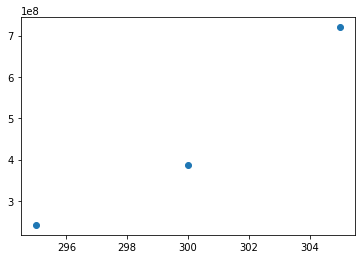

In [143]:
plt.scatter(SST_exps, B)

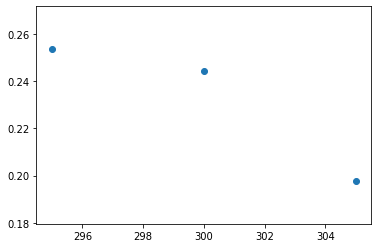

In [171]:
A_b_set = np.arange(len(RCE_exps)).astype(float)
for i_exp in range(len(RCE_exps)):
    A_b_set[i_exp] = (np.min(hist_fmse_max_set[i_exp])-hist_fmse_min_set[i_exp])/np.float(np.min(hist_fmse_max_set[i_exp]))
    
plt.scatter(SST_exps, A_b_set)

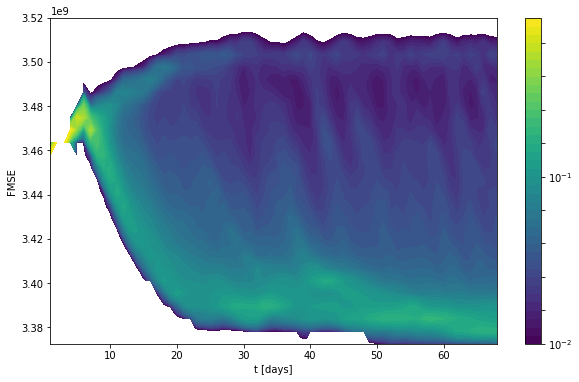

In [30]:
#plt.figure(figsize = (10, 6))

## Use logarithmic colormap
#lev_exp = np.arange(-2, 0.0, 0.05)
#levs = np.power(10.0, lev_exp)

#plt.contourf(day_range, fmse_bin_mid, np.ma.masked_where(fmse_hist_2D <= 0, fmse_hist_2D).T*delta_fmse_bin, levs, norm=colors.LogNorm())
#plt.xlabel('t [days]')
#plt.ylabel('FMSE')

#plt.ylim(ymax = 3.52e9)
#plt.colorbar()